# **Housing Prices**

Hi! In this notebook, I'll walk you through my data cleaning and exploration process and my thoughts on how to choose and validate a model. I'll talk a bit about backward elimination and forward selection, types of encoding for categorical data, main types of machine learning, and K-fold cross-validation, although not all of these will be implemented.

To get started, please select "Run All" above. If the application hangs, you may need to refresh the page and hit "Run All" again.

Let's get going by loading in our libraries and data:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import base
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import mutual_info_regression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('future.no_silent_downcasting', True)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
def make_boxplots_of_categorical_data(train_df: pd.DataFrame, col_name: str, label_name: str = "SalePrice", ylabel: str = "Sale Price ($millions)"):
    """
    This function creates boxplots for each possible category of a categorical feature/column in the training data using the label values.
    param train_df: The training data
    param col_name: The column to make boxplots of. Note that we have 1 boxplot per possible column value.
    param label_name: The numerical column to use for the boxplot values. This should be the column we're trying to predict.
    param ylabel: What to call the y axis.
    """
    # Let's make the figure
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    
    # Let's just keep the columns we need
    train_df = train_df[[col_name, label_name]]

    # For each unique category, we make a boxplot
    data = dict()
    for unique_value in train_df[col_name].value_counts().index:
        vals = (train_df[train_df[col_name] == unique_value][label_name].sort_values()/1e6).values
        data[unique_value] = vals
        
    # We also want a boxplot for NaN values, if they exist
    if train_df[col_name].isna().sum() > 0:
        vals = (train_df[train_df[col_name].isna()][label_name].sort_values()/1e6).values
        data["NaN"] = vals
    fig, ax = plt.subplots()

    # Plotting and making it pretty
    ax.boxplot(data.values())
    ax.set_xticklabels(data.keys())
    plt.xticks(rotation=90)

    plt.ylabel(ylabel)
    plt.title(col_name)

    plt.show()
    plt.close()
    
def one_hot_encoding(train_df: pd.DataFrame, col_name: str, dtype = None) -> (pd.DataFrame, pd.DataFrame):
    """
    This function takes a column in the training data and one-hot encodes it. The original column is then deleted.
    param train_df: The training data
    param col_name: The column to encode
    param dtype: Optionally setting the dtype
    return train_df: The training data after one-hot-encoding
    return encoding.columns: The list of all the new one-hot-encoded column names
    """
    encoding = pd.get_dummies(train_df[col_name])
    if not pd.isna(dtype):
        encoding = encoding.astype(dtype)
    encoding.columns = [f"{col_name}_{i}" for i in encoding.columns]
    train_df = pd.concat([train_df, encoding], axis=1).drop(columns=[col_name])
    return train_df, encoding.columns.tolist()

def k_fold_target_encoding(train_df: pd.DataFrame, original_col_name: str, num_splits: int=5, label_name: str="SalePrice") -> (pd.DataFrame, dict):
    """
    This function k-fold target encodes the original_col_name using num_splits as the number of folds.
    We also create the target encodings needed for converting original_col_name in the test data.
    param train_df: The training data
    param original_col_name: The column to encode
    param num_splits: The number of folds
    param label_name: The value we're trying to predict
    return train_df: The training dataframe after k-fold target encoding
    return test_encodings: The encodings of the original column, to be used for the test dataset
    """
    
    # Let's get the folds and set up our data
    col_name = f"{original_col_name}_Encoded"
    train_df[col_name] = train_df[original_col_name].copy(deep=True)
    
    data = train_df[[col_name, label_name]]
    mean_encodings = data.groupby(col_name).mean().to_dict()[label_name]
    
    skf = StratifiedKFold(n_splits=num_splits)
    for fold_num, (train_index, test_index) in enumerate(skf.split(train_df[[col_name]], train_df[[label_name]])):
        
        # We get our encoding values by taking the mean of each category's label_name values in the train_index folds (which contains most of the data)
        encoding_vals = data.loc[train_index].groupby(col_name).mean().to_dict()[label_name]
        # In the test_index (which is the fold that was left out), we replace with the encoded values
        train_df.loc[test_index, col_name] = train_df.loc[test_index, col_name].replace(encoding_vals)
    
    # Dealing with things that couldn't be encoded due to too few values
    bad_vals = pd.to_numeric(train_df[col_name], errors="coerce")
    bad_vals = bad_vals[bad_vals.isna()].index
    if len(bad_vals):
        train_df.loc[bad_vals, col_name] = train_df.loc[bad_vals, col_name].replace(mean_encodings)
        
    train_df[col_name] = train_df[col_name].astype(float)    
    
    # Here, we create the encodings for the test dataset, which are just the mean of each possible category.
    test_encodings = train_df[[original_col_name, col_name]]
    test_encodings = test_encodings.groupby(original_col_name).mean().to_dict()[col_name]    

    return train_df.drop(columns=[original_col_name]), test_encodings

# **Exploratory data analysis**

In [3]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [5]:
train_df.shape

(1460, 81)

In [6]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# **Checking for NaNs**

It is important to clean the data by removing or filling in NaN values, as they cannot be converted to numbers when training and thus cannot be used to compute the gradient or do the arithmetic necessary to train a model. We will start by looking at the data_description.txt to find out when a NaN is not actually a missing value.

Let me explain: Generally, we tend to assume that NaNs mean the data was not collected or was not available. The data is missing. However, in this case, NaNs sometimes have a meaning of their own. For instance, in the FireplaceQu column, NaN doesn't mean the data wasn't collected - it means the house does not have a fireplace. Since the NaN values in this column don't actually indicate missing data, we will simply fill in with a new category (since the column is categorical): NoFireplace.

In [7]:
train_df.loc[train_df["FireplaceQu"].isna(), "FireplaceQu"] = "NoFireplace"

We then do this for all the other categorical columns where NaN has a certain meaning rather than indicating uncollected/unintentionally missing data. Since the data is categorical, we will fill in with a new category. Filling in for numeric values can be a bit more complex, so we will focus on the categorical columns for now.

In [8]:
train_df.loc[train_df["PoolQC"].isna(), "PoolQC"] = "NoPool"
train_df.loc[train_df["Fence"].isna(), "Fence"] = "NoFence"
train_df.loc[train_df["MiscFeature"].isna(), "MiscFeature"] = "NoMiscFeatures"
train_df.loc[train_df["MasVnrType"].isna(), "MasVnrType"] = "NoVnr"
train_df.loc[train_df["Alley"].isna(), "Alley"] = "NoAlley"

train_df.loc[train_df["GarageCond"].isna(), "GarageCond"] = "NoGarage"
train_df.loc[train_df["GarageQual"].isna(), "GarageQual"] = "NoGarage"
train_df.loc[train_df["GarageFinish"].isna(), "GarageFinish"] = "NoGarage"
train_df.loc[train_df["GarageType"].isna(), "GarageType"] = "NoGarage"

train_df.loc[train_df["BsmtCond"].isna(), "BsmtCond"] = "NoBasement"
train_df.loc[train_df["BsmtQual"].isna(), "BsmtQual"] = "NoBasement"
train_df.loc[train_df["BsmtFinType1"].isna(), "BsmtFinType1"] = "NoBasement"
train_df.loc[train_df["BsmtFinType2"].isna(), "BsmtFinType2"] = "NoBasement"
train_df.loc[train_df["BsmtExposure"].isna(), "BsmtExposure"] = "NoBasement"

Now we look at numerical columns where the NaNs have some sort of meaning. The most obvious one to me is the MasVnrArea column. This gives the area of the masonry veneer, but as we've seen with the MasVnrType column, some houses don't have masonry veneers. Let's check if the NaNs in the MasVnrArea column correspond with the NoVnr rows in the MasVnrType column.

In [9]:
# Rows where MasVnrType is NoVnr
no_veneer = train_df[train_df["MasVnrType"] == "NoVnr"].index

# Rows where MasVnrArea is NaN
nan_vnr_area = train_df[train_df["MasVnrArea"].isna()].index

no_veneer.equals(nan_vnr_area)

False

The indices are not equal. That's odd. Let's take a closer look.

In [10]:
print(no_veneer)
print(nan_vnr_area)
print(nan_vnr_area.isin(no_veneer).all())

Index([   1,    3,    5,    8,    9,   10,   12,   15,   17,   18,
       ...
       1445, 1448, 1449, 1450, 1453, 1454, 1455, 1457, 1458, 1459],
      dtype='int64', length=872)
Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')
True


So we see that all the NaN values in MasVnrArea correspond to rows where MasVnrType is NoVnr (i.e. no masonry veneer), which makes sense, and means that the NaNs in MasVnrArea should be set to 0, as there is no area. Let's do a sanity check that all the NoVnr rows in MasVnrType correspond to either 0 or NaN in MasVnrArea, and turn the MasVnrArea NaN values to 0.

In [11]:
# Filling in MasVnrArea NaNs
train_df.loc[train_df["MasVnrArea"].isna(), "MasVnrArea"] = 0

# Sanity check - finding all the veneer areas where VnrType is no veneer.
train_df.loc[train_df["MasVnrType"] == "NoVnr", "MasVnrArea"].unique()

array([  0., 288.,   1., 344., 312.])

Now we have a problem. Some of the rows that we labelled NoVnr actually have veneer areas. What this likely means is that while some of the NaNs in the MasVnrType do correspond to no masonry veneer, some of the NaNs there were actually missing data. We were too hasty to believe the data_description.txt, and we should have some **sanity checks** in place before assuming that every NaN means something/none of the NaNs represent truly missing data. Let's set MasVnrType back to NaN where the MasVnrArea is > 0.

In [12]:
train_df.loc[(train_df["MasVnrArea"] > 0) & (train_df["MasVnrType"] == "NoVnr"), "MasVnrType"] = np.nan

We'll also do similar sanity checks for the garage, pool and basement columns. First, we set the "NoGarage" and "NoBasement" values back to NaN, and only fill in the NaN value if all the relevant columns are NaN. For the pool column, since we have PoolArea, we'll do the same thing as for MasVnrArea.

In [13]:
basement_cols = ["BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtFinType2", "BsmtExposure"]
garage_cols = ["GarageCond", "GarageQual", "GarageType", "GarageFinish"]

for basement_col in basement_cols:
    train_df.loc[train_df[basement_col] == "NoBasement", basement_col] = np.nan

for garage_col in garage_cols:
    train_df.loc[train_df[garage_col] == "NoGarage", garage_col] = np.nan

train_df.loc[(train_df["BsmtCond"].isna()) & (train_df["BsmtQual"].isna()) & (train_df["BsmtFinType1"].isna()) & (train_df["BsmtFinType2"].isna()) & (train_df["BsmtExposure"].isna()), basement_cols] = "NoBasement"
train_df.loc[(train_df["GarageCond"].isna()) & (train_df["GarageQual"].isna()) & (train_df["GarageType"].isna()) & (train_df["GarageFinish"].isna()), garage_cols] = "NoGarage"

train_df.loc[(train_df["PoolArea"] > 0) & (train_df["PoolQC"] == "NoPool"), "PoolQC"] = np.nan

There aren't any sanity checks we can do for MiscFeature, etc., so we'll leave those alone.

As for NaNs in the numerical columns, based on the data_description.txt, it looks like most of the NaNs there do genuinely mean "value was not measured/is unintentionally missing", and thus are hard to assign values for. For instance, with the LotFrontage column, which refers to how many feet of street connect to the property, we could potentially assume that NaN means 0, but we don't know for sure, so we'll leave those NaNs alone for now and later we can fill in the NaNs with the mean of the column if it looks like a column worth keeping.

If any of the categorical columns still contain NaNs and we don't want to remove the row or column, we'd probably fill the NaN in with the mode of the column (the most common category), since all the NaNs which represent something have already been filled in.

## Columns

The below returns the names of all columns containing NaNs, as well as the number of NaNs per column. Fraction_NaNs shows what fraction of the column is NaN.

In [14]:
nan_cols = pd.DataFrame(train_df.isna().sum()).rename(columns={0: "Num_NaNs"})
nan_cols["Fraction_NaNs"] = nan_cols["Num_NaNs"] / len(train_df)
nan_cols.loc[nan_cols["Num_NaNs"] > 0].sort_values(by="Fraction_NaNs")

,Num_NaNs,Fraction_NaNs
BsmtExposure,1,0.000685
BsmtFinType2,1,0.000685
Electrical,1,0.000685
MasVnrType,5,0.003425
GarageYrBlt,81,0.055479
LotFrontage,259,0.177397


If a column had a very large fraction of NaNs compared to the total number of rows, we would remove it as it will likely not be useful or provide any extra information in most cases. Columns with lots of NaNs also contribute to **sparse data**, which increases model complexity and time/computational power required to train without really adding value or increasing predictive accuracy.

Here, I don't think any of the columns have enough NaNs for me to immediately want to remove them, although LotFrontage is on the fence. For the columns with fewer NaNs, I'd prefer to remove the rows instead of columns since removing a row removes 81 values (since that's how many columns we have), while removing a column removes 1460 values (since there are 1460 rows). The longer your dataset/the more data points you have, the more data you lose by removing a column. So if we decide not to impute the NaNs in e.g. the MasVnrType, we'd remove 5 rows and lose 401 values instead of removing the whole column and losing 1460 values.

Later, we will look at boxplots and scatter plots of each column vs. the label we're predicting (the Sale Price), as well as the value counts, to get a sense of which columns are worth keeping and which we can safely throw out. In that process, we may end up removing the columns with NaNs anyway (for instance, I'd be very surprised if the year the garage was built had any impact on the sale price). Again, LotFrontage is probably a column that will be dropped very quickly if it doesn't look incredibly useful.

If the columns containing NaNs end up looking useful, though, then we'll need to fill in the NaNs somehow.

One notable exception is that if one of the columns with NaNs is a categorical column that you plan to one-hot encode, you don't have to fill the NaNs with anything - all the one-hot encoded columns will simply be 0 for that row.

## Rows

If there were lots of columns still containing NaNs, I'd also look at the NaN count of each row to see if maybe some rows contain tons of NaNs and thus are worth dropping (e.g. a row that is more than 50% NaNs is definitely worth throwing out). However, with relatively few of the columns containing NaNs, I think I'll go straight to seeing which columns/features look useful in predicting the Sale Price label.

# **Turning Categorical Data into Numbers**

## Reasoning

Turning categorical data into numerical data is essential if we choose to use a regression approach (e.g. multiple linear regression), or any neural network-based approach. These are dependent on numerical inputs.

Categorical inputs are theoretically allowed if we are using something based on decision trees (e.g. a **random forest**, which involves using multiple parallel decision trees and chooses the answer that the most trees agree with, or **gradient-boosting trees**, which uses multiple weak learner decision trees in sequence to come to a single conclusion). However, some libraries (e.g. xgboost) require numerical inputs anyway. I'd also like to demonstrate the different ways in which we can turn categorical data into numbers.

Here, we start going through the columns whose dtypes are object, meaning they are not numerical. We'll also start a list of the categorical columns not worth keeping.

In [15]:
drop_cols_categorical = []

### MSZoning

We see from the value counts that there are 5 possible values for "MSZoning" with some level of distribution. By some level of distribution, I mean that we don't see a split like 1450-2-2-2-4, in which case many of the categories would have too few values to be useful and the column wouldn't really tell us much about most of the entries. If there isn't a good distribution of categories, I find it better to get rid of the column, especially if the boxplots don't show anything significant.

In particular, if we have a poor distribution of values but one of the minority categories forms a cluster of extremely high prices, that feature column may still be useful because the minority category may indicate something that most people cannot afford (so is uncommon) but drives up the house price a lot. This is why boxplots for categorical features are useful to look at.

For MSZoning, the boxplots do seem to show some distinction in the Sale Price based on the category (e.g. there's little to no overlap between C (all) and FV house prices), so this is a column to keep.

In [16]:
train_df["MSZoning"].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

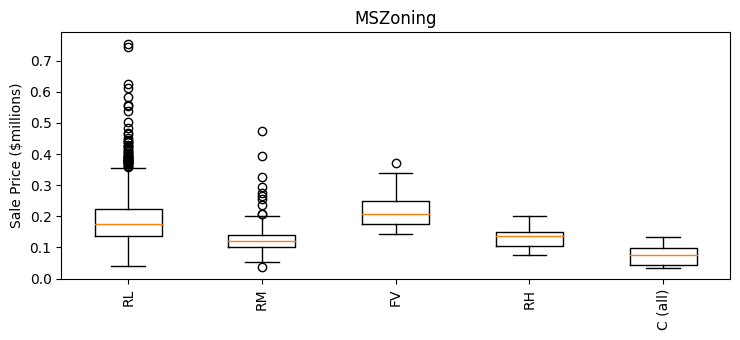

In [17]:
make_boxplots_of_categorical_data(train_df, "MSZoning")

Because there are 5 unique values, we can use **one-hot encoding** on this categorical data. One-hot encoding involves creating a new column for each possible categorical value, meaning we would have 5 new columns (one for each possible unique value). We fill in 1s where the value matches, i.e. the MSZoning_is_RL column would be set to 1 where the MSZoning column is RL. We don't have any NaNs in the MSZoning column, but if we did, we could have all the one-hot encoded columns for MSZoning be 0 where MSZoning is NaN.

One-hot encoding is good when there are very few unique categorical values in the column, such as here, because it doesn't expand the size of the data too much (which would require increased memory and power to train). However, in cases where there are too many categorical values (e.g. a list of all the first names of employees in a company - there could be hundreds of unique names!), this may not be such a good idea as it causes very sparse data.

When there is a natural scale to the categorical data (e.g. categories are [very sad, sad, neutral, happy, very happy]), one-hot encoding can be avoided by converting the categories directly into numbers (in the above example, this could be a scale from 1-5 with very sad being 1 and very happy being 5). This is called **ordinal encoding**, and is favorable due to taking less space (1 column alone instead of 1 columns for each unique value) and assigns a relative meaning to the values instead of only encoding each value's existence.

It is important to **be cautious** about doing this when the categories have no natural scale, since machine learning algorithms will naturally assign value to the order of the numbers. Since MSZoning does not have any natural scale, we'll stick to one-hot encoding.

Note that we will encode MSZoning later rather than right now, for reasons that will be explained.

### Street

Since there are just 2 possible values here, it is possible to ordinal-encode with 0 for Pave and 1 for Grvl. However, it is worth asking if this column is even useful, since Grvl only appears 6 times in the whole training set. 

If the split of value counts were more even, I would make boxplots of each unique value to see if e.g. Grvl Streets form a small cluster of extremely high or extremely low prices, and use that to give me an idea of if the column would be useful. However, there are too few Grvl values for any conclusions with this column to be useful, and any model we train might assign too much importance to the conclusions drawn from this column. I will remove this column from the training set.

In [18]:
train_df["Street"].value_counts()

Street
Pave    1454
Grvl       6
Name: count, dtype: int64

In [19]:
drop_cols_categorical.append("Street")

If you have columns/features which you aren't sure about the usefulness of, you can use backward elimination or forward selection to decide which features to use while training.

**Backward elimination** involves starting with a model with all features (or all the features you have even the slightest suspicion might be useful) and then eliminating features one by one to see if doing so improves predictions. In this case, that would mean keeping Street for now in the training data and then training a 2nd model later without Street.

**Forward selection** involves starting with only 1 feature (likely the feature you're most confident in - in this case, perhaps LotArea) and adding features one by one to see if they improve the predictions. This would mean starting without the Street feature and then adding it in later.

As far as I'm aware, Kaggle competitions allow the submission of only 1 model. Still, if I were able to train multiple models, I would personally prefer the backward elimination approach as that allows us to leverage any potential connections in the data (i.e. joint predictive ability). This is important if you have a case like below:

- High value for feature 1 + low value for feature 2 --> low label value
- Low value for feature 1 + high value for feature 2 --> low label value
- High value for feature 1 + high value for feature 2 --> high label value
- Low value for feature 1 + low value for feature 2 --> high label value

In this case, if both features are high or both features are low, that correlated to high label values, but if only one feature is high and the other is low, we get low label values. This is an extreme case and I can't think of an example where this would happen in real life, but hopefully it's an intuitive example to show why it would be important to keep both feature 1 and feature 2.

Deciding which features to include in forward selection, or to eliminate in backward elimination, can be done using the insights gained from exploratory data analysis. For categorical features with no natural scale, this would include boxplots for each unique categorical value of the SalePrice (the label), like we did above with MSZoning. For categorical features with a natural scale, those can be converted to numbers and then plotted in a scatterplot against the label just like we would for any numerical column. This helps us see visually which features seem related to the final label in some way, and will be most useful for predicting the label.

### LotShape

The data description here shows that the categories relate to how irregular the lot is:

- Reg: Normal shape
- IR1: A bit irregular
- IR2: A little more irregular
- IR3: Irregular

Because of this natural scale, we can ordinal encode the column from 0 (regular) to 1 (IR3).

Boxplots show that the average SalePrice for each category tends to be about the same at $200,000, and the spreads are kind of similar besides the high-end outliers, so I'm going to drop the column. But before that, I do want to show what it would look like if I decided to ordinal encode the column.

In [20]:
train_df["LotShape"].value_counts()

LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

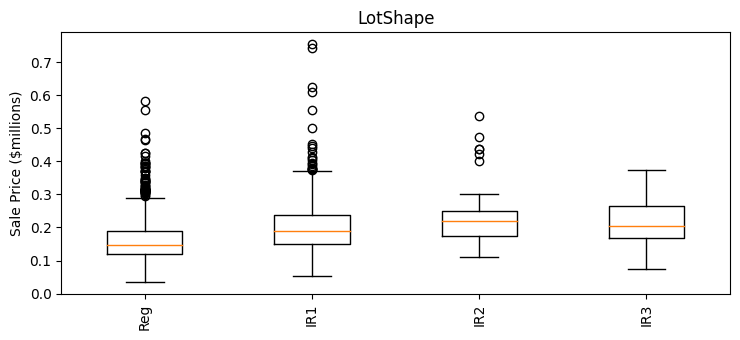

In [21]:
make_boxplots_of_categorical_data(train_df, "LotShape")

In [22]:
# This is how I'd ordinal encode the column. All the categories have been converted to numbers.
lotshape_dict = {"Reg": 0, "IR1": 1/3, "IR2": 2/3, "IR3": 1}
train_df["LotShape"] = train_df["LotShape"].replace(lotshape_dict).astype(float)
train_df["LotShape"].unique()

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [23]:
# But actually we don't even want the column, so we're going to drop it.
drop_cols_categorical.append("LotShape")

### Utilities

This columns has 2 unique values, and only 1 instance of 1 of the values, so we will drop this column as it doesn't provide useful or unique information.

In [24]:
train_df["Utilities"].value_counts()

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

In [25]:
drop_cols_categorical.append("Utilities")

### Neighborhood

There are several categories which are evenly distributed with a large number of rows per category, and the boxplots do seem to show that there's potentially some importance to neighborhood, e.g. NoRidge sale prices are always higher than IDOTRR. I've also always heard in real life that location is one of the 2 big factors in determining house price (location and square footage), so I think this is a feature worth keeping.

Realistically, it would be better to use forward selection or backward elimination to decide whether to keep this feature (rather than my intuition), but since that's not an option here, I'll just keep the column.

There are too many neighborhoods to one-hot-encode though, and there's no natural order to them, so we can't ordinal encode. This would require K-fold target encoding.

**Target encoding** is when we take the average sale price for each category (e.g. the average sale price for all rows where Neighborhood = CollgCr) and set the Neighborhood in those rows to that value. However, this comes with the massive issue of **data leakage**, where we use the target values to determine the input values, which leads to overfitting and poor generalization when trying to predict new data.

To get around this, we use **K-fold target encoding**, where we split the data into K groups, hopefully with an even distribution of the feature (i.e. each fold hopefully contains a distribution of the feature values that's similar to the distribution in the whole dataset, which can be hard if some of the possible values only appear a few times in the whole dataset). 

For each fold, we use all the *other* folds to target-encode the values. E.g. if we have 5 folds, then for Fold 1, we average the saleprice of the CollgCr neighborhood rows in Folds 2-5 to get the number we should imput CollgCr to in Fold 1. This means each fold will have a different imputed value for the CollgCr neighborhood.

Thus, for each row, we are safe from using the label value for that row to calculate that row's encoded value, mitigating the impact of data leakage.

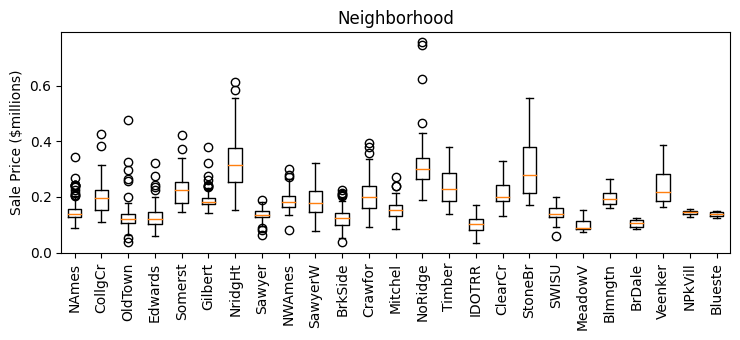

In [26]:
make_boxplots_of_categorical_data(train_df, "Neighborhood")

In [27]:
train_df["Neighborhood"].value_counts()

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

In [28]:
# sklearn has the StratifiedKFold method, which tries to ensure that the K-folds have an
# even distribution of categories that matches the overall distribution.

# We also create the test encodings so we can encode the test dataset.
train_df, neighborhood_test_encodings = k_fold_target_encoding(train_df, "Neighborhood", num_splits=5, label_name="SalePrice")
train_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Neighborhood_Encoded
0,1,60,RL,65.0,8450,Pave,NoAlley,0.000000,Lvl,AllPub,...,NoPool,NoFence,NoMiscFeatures,0,2,2008,WD,Normal,208500,198337.691057
1,2,20,RL,80.0,9600,Pave,NoAlley,0.000000,Lvl,AllPub,...,NoPool,NoFence,NoMiscFeatures,0,5,2007,WD,Normal,181500,261625.000000
2,3,60,RL,68.0,11250,Pave,NoAlley,0.333333,Lvl,AllPub,...,NoPool,NoFence,NoMiscFeatures,0,9,2008,WD,Normal,223500,199837.434426
3,4,70,RL,60.0,9550,Pave,NoAlley,0.333333,Lvl,AllPub,...,NoPool,NoFence,NoMiscFeatures,0,2,2006,WD,Abnorml,140000,209726.829787
4,5,60,RL,84.0,14260,Pave,NoAlley,0.333333,Lvl,AllPub,...,NoPool,NoFence,NoMiscFeatures,0,12,2008,WD,Normal,250000,345414.941176


Many of the other categorical columns did not look useful, whether due to a poor distribution of categories or the boxplots for each possible category looking very similar, so I'm dropping those. Some are useful (e.g. "CentralAir" [having air conditioning] increases the sale price quite a bit, which is expected), so those I'll be one-hot-encoding, ordinal-encoding, or K-fold encoding as appropriate.

We also still need to do something about the NaN values in the columns which we didn't drop. For Electrical, there is just 1 NaN value, so I decided to set it to the mode of the column, SBrkr, which is also considered the standard system according to the data description. The Electrical column is also interesting because there's a semi-grade to it, although not completely clear:

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
       
Because of this, I'd rather K-fold target encode or one-hot encode than ordinal encode this column, since I'm not sure what number I'd assign Mix if I had to ordinal encoding it.

In [29]:
train_df.loc[train_df["Electrical"].isna(), "Electrical"] = "SBrkr"
# we set the missing BsmtExposure values to the average category since the basement does exist
train_df.loc[train_df["BsmtExposure"].isna(), "BsmtExposure"] = "Av"

# Dropping columns that don't have much distribution of values, or with little visible relation to the SalePrice
drop_cols_categorical = drop_cols_categorical + ["MasVnrType", "GarageCond", "MiscFeature",
                                                 "Functional", "GarageType", "BsmtFinType2",
                                                 "Exterior2nd", "Fence", "Alley", "LandContour",
                                                 "LotConfig", "LandSlope", "Condition1",
                                                 "Condition2", "BldgType", "HouseStyle", "RoofStyle"]
train_df = train_df.drop(columns=drop_cols_categorical)

In [30]:
# Ordinal encoding
train_df["GarageFinish"] = train_df["GarageFinish"].replace({"NoGarage": 0, "Unf": 1/3, "RFn": 2/3, "Fin": 1}).astype(float)
train_df["BsmtExposure"] = train_df["BsmtExposure"].replace({"Gd": 1, "Av": 3/4, "Mn": 1/2, "No": 1/4, "NoBasement": 0}).astype(float)
train_df["BsmtFinType1"] = train_df["BsmtFinType1"].replace({"GLQ": 1, "ALQ": 5/6, "BLQ": 2/3, "Rec": 3/6, "LwQ": 2/6, "Unf": 1/6, "NoBasement": 0}).astype(float)
train_df[["CentralAir", "PavedDrive"]] = train_df[["CentralAir", "PavedDrive"]].replace({"Y": 1, "P": 0.5, "N": 0}).astype(float)

encoding_cols = ["KitchenQual", "BsmtQual", "BsmtCond", "FireplaceQu", "ExterCond", "ExterQual", "GarageQual", "PoolQC", "HeatingQC"]
train_df[encoding_cols] = train_df[encoding_cols].replace({"NoBasement": 0, "NoFireplace": 0, "NoGarage": 0, "NoPool": 0, "PO": 1/5, "Po": 1/5, "Fa": 2/5, "TA": 3/5, "Gd": 4/5, "Ex": 1}).astype(float)

In [31]:
# One-hot encoding
train_df, encoding_Heating = one_hot_encoding(train_df, "Heating", pd.Int8Dtype())
train_df, encoding_MSZoning = one_hot_encoding(train_df, "MSZoning", pd.Int8Dtype())

In [32]:
# K-fold encoding
k_fold_test_encodings = dict()
for column_name in ["Electrical", "Foundation", "RoofMatl", "Exterior1st", "SaleType", "SaleCondition"]:
    train_df, test_encodings = k_fold_target_encoding(train_df, column_name, num_splits=5, label_name="SalePrice")
    k_fold_test_encodings[column_name] = test_encodings
k_fold_test_encodings["Neighborhood"] = neighborhood_test_encodings

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

# **Feature Utility Matrix**

At this point, all columns in train_df are numerical. If we had a very small number of features, this could be a nice time to stop and look at how correlated each feature is to the label. However, we have too many columns for that, so instead, we'll just go straight for a **feature utility metric** which gives us the correlation between each feature and the label. The reason we don't take the $R^2$ between each feature and the label column is because $R^2$ assumes a linear relationship, which isn't always true.

Note that this feature utility metric will include the categorical columns we one-hot encoded, which will probably end up looking rather funny due to only being 0 or 1.

We also need to quickly fill in the NaNs we still have in the numerical columns, in LotFrontage and GarageYrBlt. We'll just be using the median for both of those, to avoid extremely large lot frontage values or very old garages skewing the average. In some cases, it makes more sense to use the mode (e.g. if the allowed values are only 0 or 1, like for our one-hot encoded columns), but it depends on the data.

In [33]:
train_df.loc[train_df["LotFrontage"].isna(), "LotFrontage"] = train_df["LotFrontage"].median()
train_df.loc[train_df["GarageYrBlt"].isna(), "GarageYrBlt"] = train_df["GarageYrBlt"].median()

In [34]:
def make_mi_scores(train_df: pd.DataFrame, label_column: str) -> pd.Series:
    """
    This function calculates the mutual information scores between the features (must be numerical!) and the label column.
    param train_df: The training data including the label column
    param label_column: The column we're predicting. Must be numerical to use mutual_info_regression
    return mi_scores: A series with features as indices indicating the mutual information between the feature and the label column
    """
    X = train_df.drop(columns=[label_column])
    
    mi_scores = mutual_info_regression(X, train_df[label_column])
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

mi_scores = make_mi_scores(train_df, "SalePrice")
mi_scores

OverallQual              0.572620
GrLivArea                0.481398
Neighborhood_Encoded     0.465371
TotalBsmtSF              0.369313
GarageCars               0.367890
YearBuilt                0.367821
GarageArea               0.364035
KitchenQual              0.334240
BsmtQual                 0.334145
ExterQual                0.319675
1stFlrSF                 0.311993
GarageYrBlt              0.303254
MSSubClass               0.274810
GarageFinish             0.264781
FullBath                 0.264121
YearRemodAdd             0.249181
TotRmsAbvGrd             0.223136
LotFrontage              0.216012
FireplaceQu              0.200961
2ndFlrSF                 0.194232
HeatingQC                0.172846
LotArea                  0.159307
Fireplaces               0.156052
BsmtFinType1             0.153849
OpenPorchSF              0.148549
BsmtFinSF1               0.147477
Exterior1st_Encoded      0.133793
BsmtUnfSF                0.120688
OverallCond              0.118781
Foundation_Enc

We've got a lot of features which have an MI of 0, meaning they tell us nothing about the SalePrice. Let's take out everything with a metric below 0.15 (this is a completely arbitrary cutoff, by the way), but make sure the one-hot encoded columns don't get thrown out.

In [35]:
feature_utility_columns_to_keep = list(set(mi_scores[mi_scores > 0.15].index.tolist() + encoding_Heating + encoding_MSZoning))
train_df = train_df[feature_utility_columns_to_keep + ["SalePrice"]]

# **Checking for Multicollinearity**

One last thing worth checking is that all our variables are truly independent of one another. Judging by just the names alone, this is probably not the case, e.g. OverallQual and OverallCond refer to the property quality and condition respectively. Personally, I have no idea how these would differ, so let's check for multicollinearity and then see if we can get rid of the highly collinear columns.

The reasons for this are twofold:

1. Reducing the dimensionality of data. In cases where we're dealing with high velocity big data, it's very important to keep memory costs in mind, and reducing the dimensionality of data makes memory costs more manageable. It also makes compute costs more manageable, which is why CNNs usually downsample images to a smaller number of pixels, because images are expensive both computationally and memory-wise.

2. Dealing with **multicollinearity** or non-independent variables. Variables are independent if they aren't influenced by each other. Multicollinearity is when our independent variables are very strongly correlated. In statistics, we generally assume variables to be independent of one another and that one variable can be changed without directly influencing the others, and machine learning is no different. Columns which seem to be very closely related (like the OverallQual and OverallCond mentioned earlier) are most likely not independent. Multicollinearity reduces the performance and explainability of machine learning models because we can't isolate the effects of changing one feature alone, so the coefficients for that feature may not be accurate.

A popular way to look for multicollinearity is to use the **variance inflation factor (VIF)**. It uses the $R^{2}$ metric, which assesses how much of the change in one variable is explained by change in the other variable. If two variables are perfectly correlated, the $R^{2}$ will be 1, and if they're orthogonal, $R^{2}$ will be 0.

VIF uses this to tell how much of the overall standard error of all other variables is explained by a single variable. A VIF of 0 indicates the variables are perfectly orthogonal, and higher values indicate more multicollinearity. Often, an upper cutoff of 5 is used to determine multicollinear variables. Let's implement the VIF below:

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Remove the label
true_train_df = train_df.drop(columns=["SalePrice"]).astype(float).copy()
  
# VIF dataframe 
vif_data = pd.DataFrame(index=true_train_df.columns, columns=["VIF"])
  
# calculating VIF for each feature 
for i in range(len(true_train_df.columns)):
    vif_data.loc[true_train_df.columns[i], "VIF"] = variance_inflation_factor(true_train_df.values, i)
    
vif_data

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF
TotalBsmtSF,5.367125
BsmtFinType1,1.361537
GarageArea,5.464379
2ndFlrSF,91.234569
Heating_Floor,inf
TotRmsAbvGrd,3.584727
Fireplaces,4.550706
Heating_Grav,inf
1stFlrSF,75.145027
MSZoning_C (all),inf


Note that the one-hot-encoded values show as inf because VIF assumes a distribution, and these columns aren't really distributions - they're just 1/0 to indicate yes/no flags. We'll ignore those columns. Any other columns with a VIF of > 5 will be removed. Let's see what we're left with:

In [37]:
columns_to_keep = vif_data[(vif_data["VIF"] == np.inf) | (vif_data["VIF"] < 5)].index.values.tolist()
train_df = train_df.loc[:, columns_to_keep + ["SalePrice"]]
train_df.shape

(1460, 30)

Doing good! We started with ~80 features, and now we're down to 30. We've reduced the dimensionality a lot without sacrificing important information, which will help with compute and memory costs without hurting (and we're even helping!) model performance.

# **Other Feature Engineering Concerns**

I'd like to take a moment to talk about common concerns during data cleaning and feature engineering, and what I'd do differently next time around.

## The Curse of Dimensionality

The **curse of dimensionality** is about how you need to exponentially increase the number of samples in order to cover a certain proportion of $d$-dimensional space, and when you have too many dimensions compared to the number of samples, you end up with sparse data. Let's say you need n samples to cover x% of a 1D line that represents the dimension space of the features. If you now expand to 2 dimensions (2 features), you need $d^{2}$ samples to cover x%. Expand to 3 dimensions (3 features) and you need $d^{3}$. Basically, the number of samples you need to sufficiently and accurately map the dimension space and avoid sparse data increases exponentially with the number of dimensions.

The big problem with this is if we haven't sufficiently mapped the dimension space for features, there's a chance that in future, we'll be asked to predict on a point which is somewhere else in the dimension space entirely that none of our samples come even close to, and our model just can't extrapolate that far out. That's why it's important for training data to run the full gamut of the possible combinations of features as much as possible. 

## Imbalanced Datasets

A lack of ability to fully map the feature dimension space is related to why many algorithms struggle with **imbalanced datasets**. Imabalanced datasets are common in logistic regression problems like fraud detection, where the majority class (non-fraudulent transactions) will be a huge percentage of all data, while the minority class (fraudulent transactions) will be very small just because they don't happen often, but the whole point of the algorithm is to differentiate between the two classes.

With the house prices dataset, it's possible that the very high-priced homes could be considered to make the dataset imbalanced, since the data given is not enough for our model to learn how to accurately predict those super high prices because we don't have a lot of samples to learn from in that range. With the dimensionality of our dataset (30 features now that we've removed a bunch) and comparatively low number of samples (1460 samples), it's very possible that the model will draw conclusions about high-priced homes based on dimensions/features which aren't actually that relevant and only look similar for these homes by coincidence.

Dealing with imbalanced datasets can be done through undersampling and/or oversampling, and the names are rather self-explanatory. Undersampling involves removing data from the majority class. The methods for doing so can be more methodical than just randomly removing data. Some examples include:

- Clustering: Find clusters of the majority class and remove data evenly from each cluster
- Tomek Links: Find cases where a majority class sample and minority class sample are each others' closest neighbor. Remove the instance of the majority class (in the image below, this would be the blue circles in the red ovals)

<img src="https://i.imgur.com/ItUxTNg.png" width="200px">

This works when you have a lot of data, but we're already short on data, so I wouldn't do this here. Instead, I'd perhaps look at oversampling. This can either involve intentionally sampling more real-life data from the minority class, or artificially creating more samples from the minority class in a process called SMOTE (Synthetic Minority Oversampling Technique). Taking our example from above, we'd make synthetic samples of the minority class like so:

<img src="https://i.imgur.com/HIeb5xC.png" width="200px">

SMOTE is potentially something I'd do with the samples of the very highest-priced homes in this dataset if I were to do this competition again, especially if I find that the model doesn't predict well on homes with very high prices.

## Principal Component Analysis

Remember how I mentioned the curse of dimensionality? Well, with this dataset, we now have 48 features after removing a bunch of columns, and 1460 rows. To me, this is a very bad a great ratio of samples to dimensions. I'd prefer this ratio to be a good deal higher. I don't have a good number off the top of my head, but intuitively, I'd use this line of reasoning:

- We need ~30 samples for a feature (assuming it's normally distributed) to follow the Central Limit Theorem and be sufficiently large. So that means 30 samples is the bare minimum we need to fill the dimension space for 1 dimensions. Even then, that is pitifully small for an ML dataset, but let's just go with it for now.
- Our dataset has 48 features or dimensions. If we follow our previous reasoning that we need n^dimensions data points to map the dimension space properly, that means we need $30^{48}$ samples, which is ridiculous, and makes it very obvious that we have WAY too many features for the amount of data available.
- One thing we could maybe have done is combine e.g. all basement-related variables into one, and same with all garage-related variables. This could reduce our number of features by maybe 5-10.
- Based on the size of our training data (1460), we should have 2-3 dimensions as 1460 is between $30^{2}$ and $30^{3}$. Not the best reasoning, I know, but it's very clear that 48 features is silly for 1460 rows.

Since we can't increase the size of the training data, we could potentially reduce the number of features even further by being a lot more aggressive with which columns we manually decide to throw out, but since that's tedious and annoying, we could also try **principal component analysis**, which aims to transform high-dimenion data into maybe 2-4 dimensions which focus on the most important features.

It's a very elegant process which appeals to the part of me that loved the math modules in my physics degree. First, you plot all your samples in $d$-dimensional space ($d$ = number of features) and find the best fit line for all the data that goes through the origin. This is principal component 1 (PC1 for short). You find the **eigenvector** of PC1 (i.e. the unit vector which tells you how important each dimension/axis is to determining PC1, with the proportions of importance being the **loading scores**).

You then find the next best fit line which goes through the origin AND is perpendicular to PC1 and find the eigenvector. PC3 is&mdash;you guessed it&mdash;the next best fit line going through the origin and perpendicular to PC1 and PC2. Keep going until you reach either d (the number of features) or n, the number of samples (if your number of samples is smaller than your number of dimensions, then you should probably fix that before anything else).

For each PC, we project the data points onto the line (i.e. draw a line between the PC and the datapoint perpendicular to the PC) and take the distance between the projected point and the origin. Note that a perfect best fit line that goes through every point will have very big distances between the projected points and the origin, while a terrible best fit line (oxymoron if I ever heard one) would have the origin be a lot closer than the point itself.

We now take the eigenvalues of the PCs, which equals the summed squared distances of the projected points to the origin, divided by (number of samples $-1$). This is the same as the sample variance formula, so we can calculate the total variation by summing the eigenvalues of all the PCs and then see what proportion of the total variation comes from each PC. We can make a **scree plot** of these percentages and see if we can just consider the first few PCs instead of all of them. E.g. if we have 48 PCs but the first two account for 96% of the total variation, we can just stick to considering PC1 and PC2, which cuts our many-dimensional data down to 2 dimensions. It's beautiful!

I'm hoping that the machine learning algorithm I've chosen below will be able to assign meaning to all the different dimensions, but if it doesn't perform well, then if I redid this, I'd definitely consider doing PCA first; I'm still rather unconvinced that all of the dimensions we have here are important, but I didn't want to let preconceived assumptions about the importance of features cloud my judgment.

# **Processing the Test Dataset**

Since we've done a lot of transformations to the train dataset, we'll need to similarly transform the test dataset to have the same format, since machine learning models expect any data they predict on to have the same format as the data they trained on.

In [38]:
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# One-hot encoding
test_df, test_encoding_MSZoning = one_hot_encoding(test_df, "MSZoning")
test_df, test_encoding_Heating = one_hot_encoding(test_df, "Heating")

# Some of the one-hot encoding columns in train_df are missing from test_df. Let's do a check.
missing_cols = (set(encoding_Heating) - set(test_encoding_Heating)).union(set(encoding_MSZoning) - set(test_encoding_MSZoning))
test_df[list(missing_cols)] = 0

# Setting NaN values
test_df.loc[test_df["Electrical"].isna(), "Electrical"] = "SBrkr"
test_df.loc[test_df["BsmtExposure"].isna(), "BsmtExposure"] = "Av"
test_df.loc[test_df["FireplaceQu"].isna(), "FireplaceQu"] = "NoFireplace"
test_df.loc[test_df["PoolQC"].isna(), "PoolQC"] = "NoPool"
test_df.loc[test_df["Fence"].isna(), "Fence"] = "NoFence"
test_df.loc[test_df["Alley"].isna(), "Alley"] = "NoAlley"
test_df.loc[test_df["MiscFeature"].isna(), "MiscFeature"] = "NoMiscFeatures"
test_df.loc[test_df["MasVnrArea"].isna(), "MasVnrArea"] = 0

test_df.loc[(test_df["MasVnrArea"] > 0) & (test_df["MasVnrType"] == "NoVnr"), "MasVnrType"] = np.nan

test_df.loc[(test_df["BsmtCond"].isna()) & (test_df["BsmtQual"].isna()) & (test_df["BsmtFinType1"].isna()) & (test_df["BsmtFinType2"].isna()) & (test_df["BsmtExposure"].isna()), basement_cols] = "NoBasement"
test_df.loc[(test_df["GarageCond"].isna()) & (test_df["GarageQual"].isna()) & (test_df["GarageType"].isna()) & (test_df["GarageFinish"].isna()), garage_cols] = "NoGarage"

# Ordinal encoding
test_df[["CentralAir", "PavedDrive"]] = test_df[["CentralAir", "PavedDrive"]].replace({"Y": 1, "P": 0.5, "N": 0}).astype(float)
test_df["GarageFinish"] = test_df["GarageFinish"].replace({"NoGarage": 0, "Unf": 1/3, "RFn": 2/3, "Fin": 1}).astype(float)
test_df["BsmtExposure"] = test_df["BsmtExposure"].replace({"Gd": 1, "Av": 3/4, "Mn": 1/2, "No": 1/4, "NoBasement": 0}).astype(float)
test_df["BsmtFinType1"] = test_df["BsmtFinType1"].replace({"GLQ": 1, "ALQ": 5/6, "BLQ": 2/3, "Rec": 3/6, "LwQ": 2/6, "Unf": 1/6, "NoBasement": 0}).astype(float)

encoding_cols = ["KitchenQual", "BsmtQual", "BsmtCond", "FireplaceQu", "ExterCond", "ExterQual", "GarageQual", "PoolQC", "HeatingQC"]
test_df[encoding_cols] = test_df[encoding_cols].replace({"NoBasement": 0, "NoFireplace": 0, "NoGarage": 0, "NoPool": 0, "PO": 1/5, "Po": 1/5, "Fa": 2/5, "TA": 3/5, "Gd": 4/5, "Ex": 1}).astype(float)

# K-fold encoding
for col_name, encodings in k_fold_test_encodings.items():
    test_df[col_name] = test_df[col_name].replace(encodings).astype(float)
    test_df = test_df.rename(columns={col_name: f"{col_name}_Encoded"})

test_id_col = test_df["Id"]
test_df = test_df[train_df.drop(columns=["SalePrice"]).columns]

test_df.head()

,BsmtFinType1,Heating_Floor,TotRmsAbvGrd,Fireplaces,Heating_Grav,MSZoning_C (all),LotArea,ExterQual,KitchenQual,Heating_Wall,...,Heating_GasW,YearBuilt,Heating_GasA,MSSubClass,MSZoning_FV,HeatingQC,FullBath,Neighborhood_Encoded,Heating_OthW,BsmtQual
0,0.500000,0,5,0,False,False,11622,0.6,0.6,False,...,False,1961,True,20,False,0.6,1,145939.353497,0,0.6
1,0.833333,0,6,0,False,False,14267,0.6,0.8,False,...,False,1958,True,20,False,0.6,1,145939.353497,0,0.6
2,1.000000,0,6,1,False,False,13830,0.6,0.6,False,...,False,1997,True,60,False,0.8,2,192475.962312,0,0.8
3,1.000000,0,7,1,False,False,9978,0.6,0.8,False,...,False,1998,True,60,False,1.0,2,192475.962312,0,0.6
4,0.833333,0,5,0,False,False,5005,0.8,0.8,False,...,False,1992,True,120,False,1.0,2,308764.353531,0,0.8


One thing I'd like to check is that everything in test_df is numerical as expected. If not, we may get an error if we run the test data through a model that's expecting only numerical inputs. Let's see which columns in test_df have the object dtype.

In [39]:
x = pd.DataFrame(test_df.dtypes).rename(columns={0: "Dtypes"})
x[x["Dtypes"] == "object"]

,Dtypes


Okay, all good with datatypes! One thing I was worried about was if the test_df contains some Neighborhood values which weren't in the training set, in which case there would be no mapping for the new neighborhood. If your model requires numerical inputs and your test data has some columns which are originally categorical, you need to ensure all the columns and values can be converted to numerical as needed, and with K-fold target encoding, if we don't have an encoding for a certain categorical value, that can be a problem. It seems we're all good in this case, though.

We still need to deal with NaNs in the test dataset. We'll need to carefully decide whether to fill with the mean, median or mode of the train dataset column. Note that we don't want to fill NaNs in the test dataset with data derived from the test dataset itself, because if we want to use the model in future on streaming data or on singular houses, we'll run into problems of not actually having anything to average/median/take the mode of.

I'll be averaging float columns that must stay within a certain range (e.g. BsmtQual can only be between 0 and 1), since there aren't any strange outliers pulling the average in any direction. For things like YearBuilt, where outlier values from the 1800s can significantly skew the average, I'll use the median. If it's a column that can only be 0 or 1, I'll take the mode.

Please note that the method below of filling in NaNs in the test data is very ugly. In a production setting, I'd hope that the data engineer (which may be me) would set up the data pipeline to handle NaNs automatically.

In that case, it would also be worth looking at adding any new test entries to the existing list of all entries (i.e. train_df) if allowed, and recalculating the fill_df values from time to time including all the new data.

In [40]:
avg_cols = ['BsmtFinSF1', 'BsmtFinType1', 'BsmtQual',
 'ExterQual',
 'FireplaceQu',
 'GarageFinish',
 'HeatingQC',
 'KitchenQual',
 'Neighborhood_Encoded']

median_cols = ['Fireplaces', 'FullBath', 'GarageYrBlt', 'LotArea', 'LotFrontage', 'OverallQual', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']

mode_cols = ['Heating_Floor',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'MSSubClass',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM']

# It looks like the feature utility metric and VIF give slightly different results each time, which is bothersome, to say the least.
# So we keep the full list of possible columns and select the ones that actually exist this time around.

avg_cols = [i for i in avg_cols if i in train_df.columns]
median_cols = [i for i in median_cols if i in train_df.columns]
mode_cols = [i for i in mode_cols if i in train_df.columns]

In [41]:
fill_df = pd.Series(index=avg_cols + median_cols + mode_cols)

fill_df[avg_cols] = train_df[avg_cols].mean()
fill_df[median_cols] = train_df[median_cols].median()
fill_df[mode_cols] = train_df[mode_cols].mode().iloc[0]

In [42]:
test_df = test_df.fillna(fill_df)

# **Choosing a Model**

Now that data cleaning is done, we can move on to everyone's favorite part, choosing a model! There are a lot of models we could use for predicting house prices. [This paper](https://www.tandfonline.com/doi/full/10.1080/09599916.2022.2070525) mentions a lot of possible models that have shown promising results, including random forests, gradient boosted trees, neural networks, genetic algorithms, support vector machines, and fuzzy logic.

All machine learning, no matter which method you choose, relies on learning through the **minimization of a loss function** during training. For regression problems (which predicting housing prices is an example of), using the squared error (i.e. the square of the residual between the expected and true label value) is a common choice. 

We then use **back-propagation** to determine the gradient of the error. If you remember your multivariable calculus classes, you'll remember that the negative gradient tells us the direction of the steepest descent. If we visualize the error space as an N-dimensional function, where N is the number of parameters that can be tuned during training (e.g. weights and biases in a neural network), we want to find a nice valley in the error space that minimizes the error function, so we want to go in the direction of steepest descent.

So by calculating the gradient based on the current parameter values, we can move in the direction of steepest descent and land somewhere else with different parameter values, and through this process, the parameters will get tuned until hopefully we're in a deep valley in the error function.

## Choosing and Validating a Model

I'm going to make the rather arbitrary choice to use gradient-boosted trees. I don't have much of a reason for this besides that gradient-boosted trees are generally considered to work better than random trees based on the papers I've looked at, and they're fairly simple to implement in Python and don't require as much computational power to train as e.g. deep-learning neural networks, which would probably be overkill for a dataset with <1500 rows and not that many features.

If this weren't a Kaggle notebook, I would try a few different model types. What I will be doing here is implementing **K-fold cross validation** to assess the model results. This uses a similar concept to K-fold target encoding of creating folds in the data. Say we have 3 folds. We'd then go through as follows:

- Model 1: Uses folds 1 and 2 to train, uses fold 3 to test
- Model 2: Uses folds 1 and 3 to train, uses fold 2 to test
- Model 3: Uses folds 2 and 3 to train, uses fold 1 to test

Generally, you'd use more folds than this. 5 seems to be a popular number and a reasonable minimum number of folds, since the 80-20 split is a rather popular one for train vs test data. The models should all have the same **hyperparameters** (i.e. parameters which you set yourself, like learning rate or choosing the error function - these are not the parameters tuned by the model). The point of the folds is that we get an error rate that is independent of exactly which data is being used for testing, since you eventually end up testing on all the data.

You can then do this validation for every model you're testing or all the hyperparameter combinations you're trying for each model type. There's certainly a lot of patience involved, which is why tools like [Azure's Automated Machine Learning](https://learn.microsoft.com/en-us/azure/machine-learning/concept-automated-ml?view=azureml-api-2) are popular. This tool automatically creates pipelines to try different models and hyperparameters for you, which takes out a lot of the tedium of manually changing and testing different hyperparameters.

## An Aside on Types of Machine Learning

There are 3 basic categories of machine learning:

- Supervised learning. This involves anything where we're trying to predict something that's already known, such as classifying whether a photo shows a cat or dog, or predicting some known numerical output like the price of a house.
    - Numerical predictions like the amount of rain we expect to see in a year in inches are linear regression problems.
    - Logistic regression involves predicting the probability of a binary outcome (e.g. whether someone will develop diabetes).
- Unsupervised. This would be something like k-means clustering, where we try to form categories of similar data points like when building customer profiles, but there's not necessarily a right answer besides whatever gives clusters with low intra-cluster distance and high distance between clusters. The training data doesn't include what the output should be.
- Reinforcement learning. This is where a machine learning algorithm has its behavior reinforced with rewards, or penalized with punishments. This is generally used for algorithms that learn to play video games.

Note that language models (looking at you, ChatGPT) come under their own special category called self-supervised learning, and are outside the scope of this notebook.

The loss function used will depend on what category of machine learning you're using.

# **Choosing Which Gradient Boosted Trees Library to Use**

There are several possible libraries we can use for our gradient-boosted trees, including:

- XGBoost
- LightGBM
- Catboost

Since we went through all the trouble of turning the categorical columns numerical, we may as well use XGboost for our gradient boosted trees.

NOTE: It looks like XGboost is actually capable of handling numerical columns now, unlike in the past, so we didn't actually need to do all that conversion from categorical to numerical. In general, the ability to handle categorical columns is one of the reasons why decision tree-based methods are very popular, as many of the other methods out there (namely neural networks) simply don't handle non-numerical data and needs them to be encoded to numbers beforehand.

## An Aside on Encoding

While encoding the categorical data to numbers was rather straightforward here, encoding gets quite interesting when we get into **transformers**, where we're often encoding words into numbers (note that transformers are the basis of big-name LLMs like Bard and ChatGPT). You have to have **positional encoding** to keep the order of the words, **word embeddings** to essentially create a vector space mapping the meanings of words (words with similar meanings will be close together in vector space), as well as **self-attention** to encode the relations between words in a sentence (e.g. whether "it" refers to the subject "food" or object "kitchen" of the sentence in "The food came out of the kitchen and it was good"). That's well outside the scope of this notebook, though. Maybe for a different competition.

In [43]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import logging
logger = logging.getLogger(__name__)

# Let's scramble the rows first, just in case they're ordered.
# We want our data to be as random in order as possible.

train_df = train_df.sample(frac=1, random_state=1045).reset_index(drop=True)

# X is the true training data (label column removed) and Y is the column we're predicting.

X = train_df.drop(columns=["SalePrice"])
y = train_df[["SalePrice"]]

# We're going to just take from the training data, 10% as validation (note that 1/num_splits = fraction for validation)
# If I had more data, I'd use 20%, but we're already pretty short on data.

num_splits = 10

# Honestly, these two hyperparameters are rather arbitrary and would probably be decided through trial and error.

num_boost_round = 400
max_depth = 8

# I am setting the random state seed to my latest Scrabble score because there is no reason not to.
# In all seriousness, the whole point of the random_state is that it's random, and ideally, your model
# shouldn't be affected by what the value is, although there are certainly cases where it does affect the outcome anyway.

params =   {
    'objective': "reg:squarederror",
    'tree_method':'hist',
    'learning_rate': 0.02,
    'max_depth': max_depth,
    'seed': 102, 
    'eval_metric': "rmse",
    'early_stopping_rounds': None,
}

# XGB has its own function for K-fold cross-validation called cv, which would be helpful if it actually ran properly on Kaggle.
# Oh well. Let's do this the long way.

train_results = pd.DataFrame(0.0, index=range(num_boost_round), columns=range(num_splits))
validation_results = pd.DataFrame(0.0, index=range(num_boost_round), columns=range(num_splits))
train_results.columns.names = ["Fold"]
validation_results.columns.names = ["Fold"]
train_results.index.names = ["Iteration"]
validation_results.index.names = ["Iteration"]

skf = StratifiedKFold(n_splits=num_splits)

In [44]:
for fold_num, (train_index, val_index) in enumerate(skf.split(X, y)):
    
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    
    # After each iteration of training, the model will predict on the validation set to see what the error rate is.

    X_val = X.loc[val_index]
    y_val = y.loc[val_index]
    
    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=False)
    dtest_reg = xgb.DMatrix(X_val, y_val, enable_categorical=False)
    
    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
    results = dict()
    
    clf = xgb.train(params = params,
                    dtrain=dtrain_reg,
                    num_boost_round = num_boost_round,
                    evals=evals,
                    evals_result=results,
                    verbose_eval=0)
    
    validation_results[fold_num] = results["validation"]["rmse"]
    train_results[fold_num] = results["train"]["rmse"]

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Let's go through the above code quickly.

## Num_boost_round and max_depth

Num_boost_round is just the number of iterations, which, as we've established, is also the number of gradient boosting trees to have in sequence. Max_depth is how many levels each tree can have, and helps prevent overfitting. Other possible parameters to avoid overfitting include:

- min_child_weight: How many samples are accounted for by a given node
- gamma: Minimum loss reduction required to split a node further
- max_leaves: Pretty self-explanatory

## Validation Data and Early Stopping

What's the early_stopping_rounds argument? When turned on, it's used to help avoid overfitting. For people unfamiliar, **underfitting** is when our model doesn't accurately predict anything - it hasn't been trained enough and so all the parameters are still too close to their initial random values. Basically, the model hasn't learned the trends of the data well enough yet and it's like there's still an element of random guessing to the predictions.

**Overfitting** is when we've learned the training data too well to the point where we can't generalize to anything else. The model has assigned too much meaning to very small variations in the data rather than looking at overall trends. The model will perform extremely well when trying to predict the training data, but will struggle to predict well on novel data it hasn't seen before. This is what I mean by assigning too much value to small variations:

<img src="https://imgur.com/7TWNfFZ.png" height="400px">

Overfitting is dangerous because it can be hard to catch. It's a big part of why machine learning always has the mantra that you CANNOT taint your testing data with your training data and vice versa. If your training and testing data get muddled together (e.g. if you used both training and testing data to K-fold encode), the model may perform much better on the testing data than if the testing data were completely novel, because the testing data isn't actually novel anymore, and that means you may think your model is doing great on novel data when actually it wouldn't and the model's already overfitted.

Training to the point of overfitting is also just a waste of time, because the optimal point of training is before you've reached that point, so it's good if you can stop before you get to that point. We can very roughly consider the errors in predictions to look something like this, based on iterations of training:

<img src="https://i.imgur.com/2xpG7Ia.png" width="400px" height="400px">

At the end of each iteration, the model predicts on the validation data just to see how it's doing. Once we're at the point where the error rate when predicting on the validation data is starting to just get worse, we can safely stop the training instead of going all the way to whatever our predetermined max number of iterations is. This is called **early stopping**.

You may be wondering at this point why we're setting early_stopping_rounds to None, which is equivalent to not activating it at all. The reason is because we're doing K-fold cross-validation and want the same number of iterations between different models for a fair comparison. In gradient boosted trees, each iteration adds 1 tree, so the model architecture changes depending on the number of iterations. In order to have a fair comparison of each fold, we want to have the same number of trees, and so are not enabling early stopping.

What I'd do if going through the full process of deciding hyperparameters and whatnot is to not turn on early stopping for any of my initial hyperparameter tests. Each set of hyperparameters would be tested through K-fold cross-validation like above, and then at the end, I'd see which set of hyperparameters gave the best results. I'd then retrain the model using that set of hyperparameters and turning on early stopping.

If I were implementing something like a neural network where the architecture (for neural networks, this would be the number of layers and the number of neurons per layer, as well as which type of layer each layer is) stays constant no matter the number of iterations, I'd turn on early stopping even in the K-fold cross-validation step of testing different hyperparameters.

In this case, even though we're not using the validation data to enable early stopping, we do still want to predict on validation data to get a better idea of if our number of iterations is set too high and to be able to combine the prediction metrics for each K-fold to get the overall model prediction accuracy and other metrics.

Let's plot the root mean squared error across iterations for the training and validation data for each K-fold and see what it looks like.

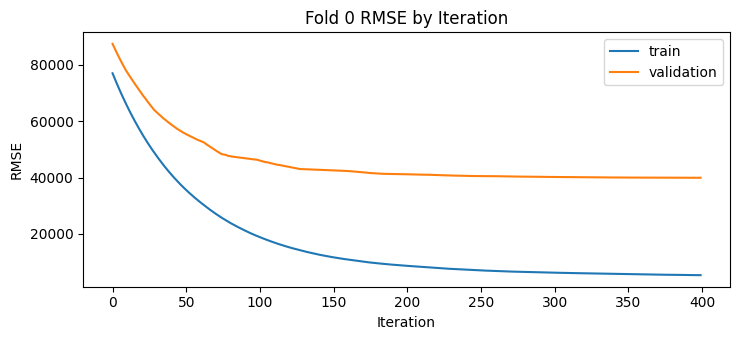

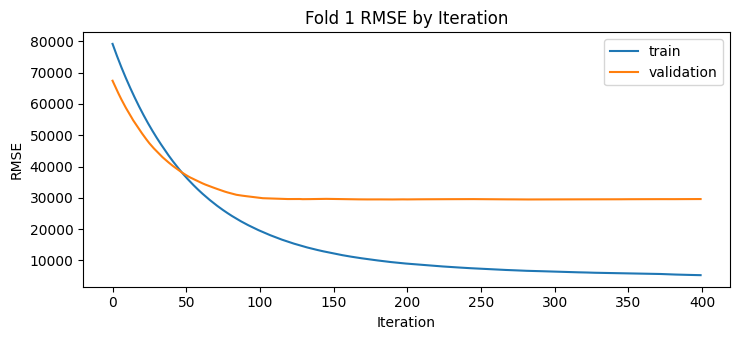

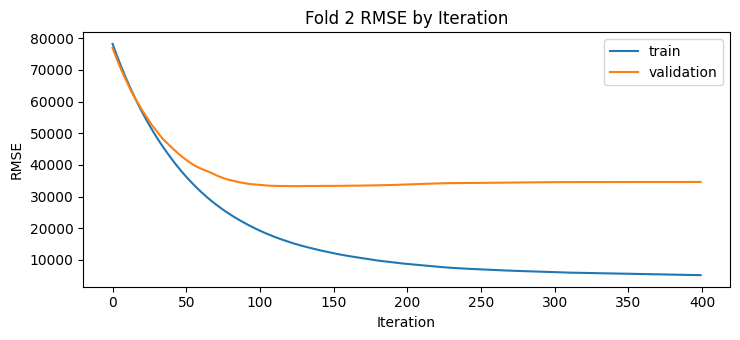

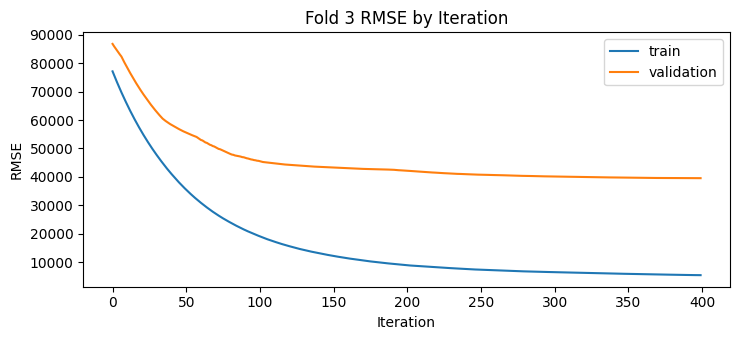

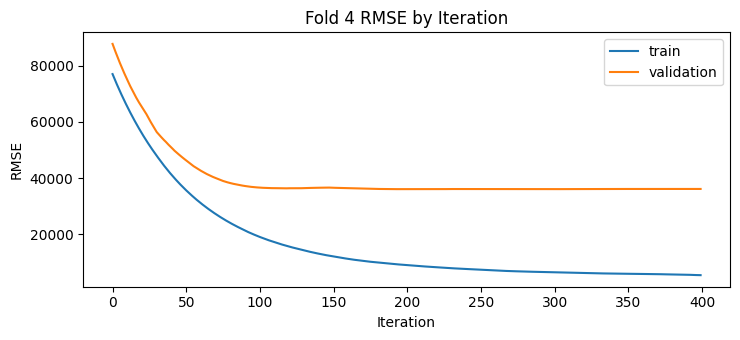

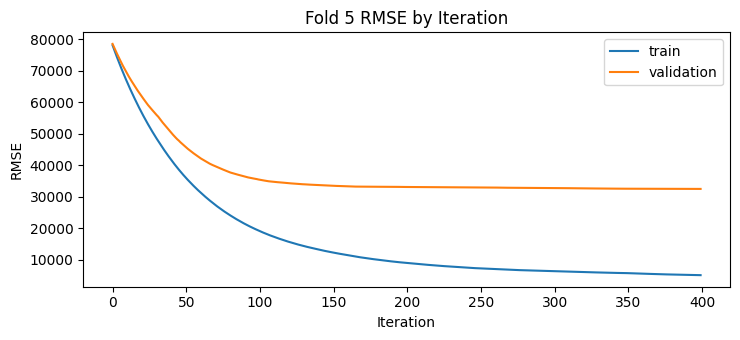

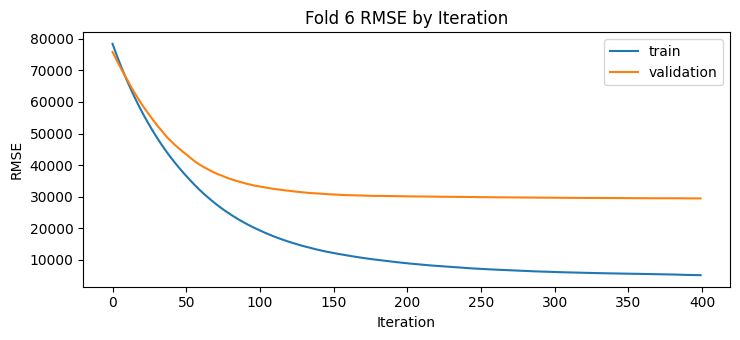

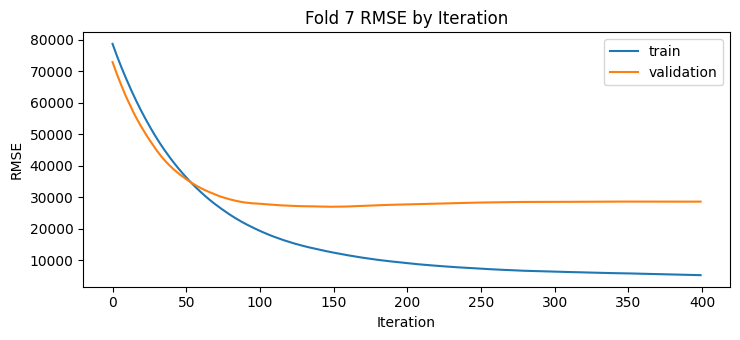

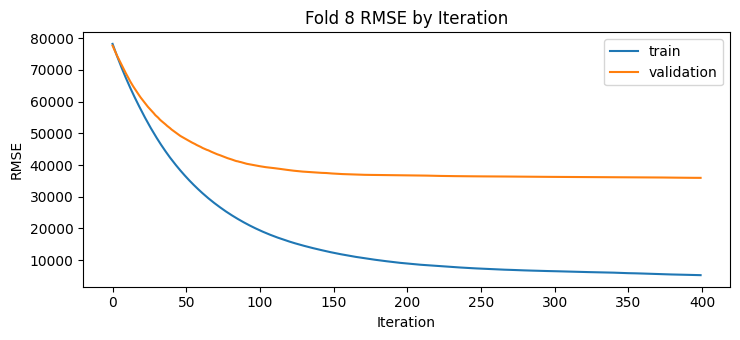

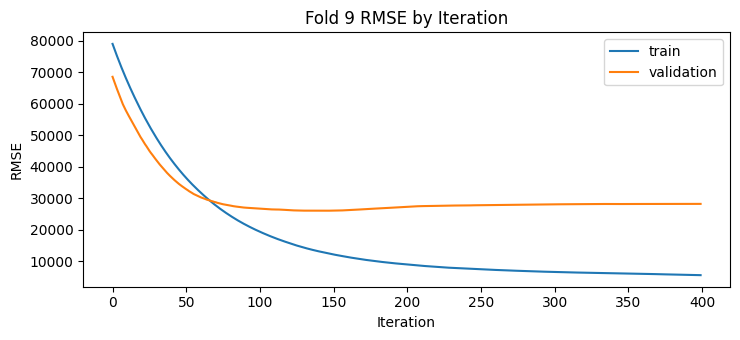

In [45]:
for fold in range(num_splits):
    plt.plot(train_results.index, train_results[fold], label="train")
    plt.plot(validation_results.index, validation_results[fold], label="validation")
    plt.legend()
    
    plt.title(f"Fold {fold} RMSE by Iteration")
    plt.ylabel("RMSE")
    plt.xlabel("Iteration")
    
    plt.show()
    plt.close()

We can see that the training errors start at around the same mark each time (\\$80,000) and while training error goes to nearly 0, validation error caps out at around \\$40,000 each time. Interestingly, we don't see validation error start increasing again, which would indicate overtraining. Instead, we just don't improve past a certain point, meaning our hyperparameters aren't very good. Mind that \\$40k is a significant fraction of usual housing prices (the median SalePrice in the training data is \\$163k), so we're doing quite badly.

The lack of obvious overfitting is likely due to us setting the max_depth of the trees; if we allowed the trees to keep splitting into more and more layers, we could easily end up with one leaf for every single piece of training data, would would absolutely be overfitting.

Normally, I wouldn't actually plot each K-fold individually - I'd average over each iteration and just plot the average validation and training errors as below, and then have these plots for each set of hyperparameters I'm testing.

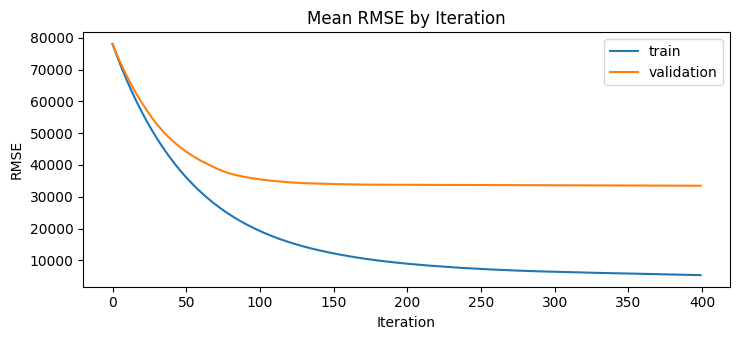

In [46]:
plt.plot(train_results.index, train_results.mean(axis=1), label="train")
plt.plot(validation_results.index, validation_results.mean(axis=1), label="validation")
plt.legend()

plt.title(f"Mean RMSE by Iteration")
plt.ylabel("RMSE")
plt.xlabel("Iteration")

plt.show()
plt.close()

We can see from the above that we really don't need as many iterations as we currently have. Even half the number of iterations would be fine.

I haven't really talked about my choice of error metric, which is root mean squared error. This is a fairly common one for linear regression problems. For classification, it's useful to make an **ROC curve** of the true positive rate vs. the false positive rate, and take the area under that curve (the **AUC**). The greater the area, the better. If you have more than 2 categories, you can make ROC curves and take the AUC for each category you're predicting for.

# **Retraining and Predicting on Test Set**

Since we're not testing different hyperparameters, it's now time to retrain our model and predict on the test set! Because the validation error becomes flat rather than ever increasing, I don't think early stopping would actually be helpful, so I'm going to retrain on ALL the training data rather than including a validation set (note that if we wanted to include early stopping, a validation set would be necessary). This is not something I recommend doing in a production setting, but given how short we are on data, I'd like to use as much data for training as possible rather than holding anything out for validation.

As mentioned previously, we really don't need as many iterations as we had in training; even half would be fine.

In [47]:
num_boost_round = 200
dtrain_reg = xgb.DMatrix(X, y, enable_categorical=False)

clf_final = xgb.train(params = params,
                dtrain=dtrain_reg,
                num_boost_round = num_boost_round,
                verbose_eval=0)

In [48]:
predicted_prices = clf_final.predict(xgb.DMatrix(test_df, enable_categorical=False))
final_predictions = pd.DataFrame({"Id": test_id_col, "SalePrice": predicted_prices})
final_predictions.to_csv('submission.csv', index=False)

# **Final Thoughts**

Okay, so our model doesn't do that great, but we're not always going to get it right the first time. Hopefully, you still found this notebook interesting and helpful! While it's not very suitable for total beginners with no machine learning knowledge whatsoever, I've designed it to be understandable for people with very basic knowledge of machine learning. This notebook is meant to mostly be an assay on data cleaning and exploration, rather than focused on designing and testing the model itself.

I remember when starting out with machine learning, I found the data cleaning process to be tedious and boring and tried to skip it as much as possible. However, it's important to start with the fundamentals, but since a lot of people seem to assume knowledge of the fundamentals as a foregone conclusion, it can be hard to know what you don't know and to find a resource that takes you through the process step-by-step.

Have a great day!